<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/Deep_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [198]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [199]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
av_vols = np.mean(train_vols[3], axis = 0)

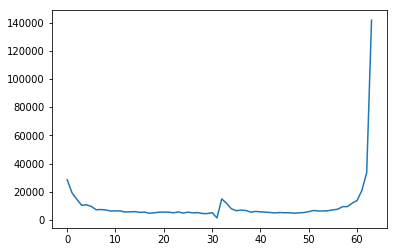

In [31]:
plt.plot(av_vols)

In [0]:
#create covariates - currently one hot vector 64 dims but experiment with different ideas 
def create_covariate_data(input_data, freq = 64): #this is assuming that data starts at beginning of day and ends at last bin of the day 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  covariate_vectors = np.zeros((num_series, len_series, freq+1))
  
  for n in range(num_series):
    for d in range(days): 
      for t in range(freq): 
        one_hot = np.zeros(freq)
        one_hot[t] = 1
        covariate_vectors[n, d*64 + t, 0] = input_data[n, d*64 + t]
        covariate_vectors[n, d*64 + t, 1:] = one_hot
        
  return covariate_vectors

In [40]:
64*3

192

In [0]:
train_volume = train_vols[0:10].reshape((10,-1))

norm_train_vols = np.zeros((10, 29568))
for i in range(10): 
  norm_train_vols[i] = train_volume[i]/np.amax(train_vols[i])
  
T = 64*3
new_train_data = norm_train_vols[:,:T]

covars_data = create_covariate_data(new_train_data)

covars_data = torch.FloatTensor(covars_data)

In [0]:
class GlobalEffects(nn.Module): 
  def __init__(self, input_size, num_factors, hidden_size = 1, batch_size = 1, output_size = 1, num_layers = 1): 
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.lstm1 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm2 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm3 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm4 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm5 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm6 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm7 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm8 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm9 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.lstm10 = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    
    self.w = torch.nn.Parameter(torch.zeros(batch_size, num_factors))
    
  def init_hidden(self): 
    return torch.zeros(self.num_layers, self.batch_size, self.hidden_size)

  def forward(self, input_data, hidden): 
    x = input_data[:,1:]
    g1, hidden = self.lstm1(x.view(len(x), self.batch_size, -1))
    g2, hidden = self.lstm2(x.view(len(x), self.batch_size, -1))
    g3, hidden = self.lstm3(x.view(len(x), self.batch_size, -1))
    g4, hidden = self.lstm4(x.view(len(x), self.batch_size, -1))
    g5, hidden = self.lstm5(x.view(len(x), self.batch_size, -1))
    g6, hidden = self.lstm6(x.view(len(x), self.batch_size, -1))
    g7, hidden = self.lstm7(x.view(len(x), self.batch_size, -1))
    g8, hidden = self.lstm8(x.view(len(x), self.batch_size, -1))
    g9, hidden = self.lstm9(x.view(len(x), self.batch_size, -1))
    g10, hidden = self.lstm10(x.view(len(x), self.batch_size, -1))

    g = torch.cat((g1.view(-1,1), g2.view(-1,1), g3.view(-1,1), g4.view(-1,1), g5.view(-1,1), g6.view(-1,1), g7.view(-1,1), g8.view(-1,1), g9.view(-1,1), g10.view(-1,1)), dim=1)
    #fixed_effects = torch.sum(g.view(-1, 1) * self.w)
    #print('f', fixed_effects.shape)
    
    fixed_effects = torch.zeros(g.shape[0])
    for i in range(g.shape[0]): 
      fixed_effects[i] = torch.dot(self.w.view(-1), g[i])

    return fixed_effects
    
    #NEED TO ADD AN ATTENTION LAYER HERE 
      

In [0]:
class DF_RNN(nn.Module): 
  def __init__(self, input_size, hidden_size, batch_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size

    self.rnn = nn.RNN(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = 1)
    
  def init_hidden(self): 
      return torch.zeros(1, self.batch_size, self.hidden_size)
    
  def forward(self, input_data, hidden, fixed_effects, gaussian_likelihood): 
    z = input_data[:,0]
    x = input_data[:,1:]
    rnn_out, hidden = self.rnn(x.view(len(x), self.batch_size, -1))
    sigma = rnn_out.view(-1) #might need to separate all this out as sigma will be a vecotr?
    r = torch.zeros(sigma.shape[0])
    for i in range(sigma.shape[0]):
      r[i] = torch.distributions.normal.Normal(0, sigma[i]).rsample()
    u = fixed_effects + r
    
    if gaussian_likelihood == True: 
      likelihood = self.likelihood_Gaussian(z, fixed_effects, sigma)#????
    
    else: 
      likelihood = self.likelihood_nonGaussian()
    
    return likelihood
   
  def likelihood_Gaussian(self, z, f, sigma):
    log_p = torch.zeros(len(z))
    for i in range(len(z)): 
      print('doff', z[i] - f[i])
      log_p[i] = torch.distributions.normal.Normal(0, sigma[i]).log_prob(z[i] - f[i])
      print('sigma', sigma[i])
      print('logp', log_p[i])
     
    p = torch.exp(log_p)
    likelihood = torch.prod(p)
      
    return likelihood 
  
  
  def likelihood_nonGaussian(self, ):
    pass

In [0]:
global_model = GlobalEffects(64, 10)
local_model = DF_RNN(64, hidden_size = 1, batch_size = 1, output_size = 1)

In [0]:
learning_rate = 0.001
batch_size = 10
num_epochs = 10

In [0]:
loss_function = torch.nn.NLLLoss()
optimiser = torch.optim.SGD(list(global_model.parameters()) + list(local_model.parameters()), lr = learning_rate)

#optimiser_global = torch.optim.SGD(global_model.parameters(), lr = learning_rate)
#optimiser_local = torch.optim.SGD(local_model.parameters(), lr = learning_rate)

train_loss = []

for t in range(num_epochs): 
  global_model.zero_grad()
  global_hidden = global_model.init_hidden()
  
  local_model.zero_grad()
  local_hidden = local_model.init_hidden()
  
  data_batch = covars_data
  
  batch_loss = 0 
  
  for i in range(batch_size): 
    data = data_batch[i]
    
    fixed_effects = global_model(data, global_hidden)
    print('f', fixed_effects.shape)
    likelihood = local_model(data, local_hidden, fixed_effects, gaussian_likelihood = True)
    print('lik', likelihood.shape)
    
    batch_loss += loss_function(likelihood, data)
    
  optimiser.zero_grad()
  
  batch_loss.backward()

  optimiser.step()

  train_loss.append(batch_loss.item())
  
    
  print("Epoch: ", t, "loss: ", batch_loss.item())
    
    
  
  